# Heteroskedasticity

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/statistics/comments/1ckl864/q_how_does_conditional_heteroskedasticity/).

> How does conditional heteroskedasticity underestimate standard errors?
>
> Shouldn't it depend on the data set? What if, by increasing the independent variable X, the variance in my residuals is actually increasing? Would that not mean the standard error increases, thereby REDUCING the t-stat and increasing the risk of type 2 error instead of type 1 error?

Heteroskedasticity does not always cause a linear regression model to underestimate standard errors -- it is also possible to overestimate.
I'll construct one example of each type, so we can see how.

And then we can address two broader questions:

1. When do we have to worry about heteroskedasticity,

2. And what can we do about it?

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/heterosked.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [174]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

In [175]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

## What is heteroskedasticity?

Linear regression is based on a model of the data-generating process where the independent variable $y$ is the sum of

* A linear function of $x$ with an unknown slope and intercept, and

* Random values drawn from a Gaussian distribution with mean $\mu=0$ and unknown standard deviation, $\sigma$, that does not depend on $x$.

So what happens if we violate these assumptions?

* If $y$ is a non-linear function of $x$, regression finds the best linear fit to the data, which might not be very good.

* If $\mu$ is not zero and it does not depend on $x$, the estimate of the intercept will be biased.

* If $\mu$ is not zero and it *does* depend on $x$, the estimate of the slope will be biased, and probably the intercept, too.

* If $\sigma$ depends on $x$, the data-generating process is heteroskedastic. In general, heteroskedasticity doesn't bias the slope or the intercept, but it might bias the standard error of the estimated parameters.

To see why, let's generate some data.
First, I'll draw `xs` from a normal distribution.

In [206]:
np.random.seed(17)

xs = np.random.normal(10, 1, size=500)
xs.sort()

If `sigma` is constant, the model is homoskedastic.

In [207]:
sigma = 1.3
ys = 0.5 * xs + np.random.normal(0, sigma, size=len(xs))

homosked = pd.DataFrame(dict(x=xs, y=ys))
homosked.corr()

,x,y
x,1.00000,0.35021
y,0.35021,1.00000


Now, to generate heteroskedastic data, I'll make use `interpolate` to construct a function where `sigma` depends on `x`.

In [208]:
from scipy.interpolate import interp1d

def interpolate(xs, sigma_seq):
    return interp1d([6, 10, 14], sigma_seq)(xs)

For the first example, `sigma` increases linearly with `x`.

In [209]:
sigmas = interpolate(xs, [0.0, 3.0, 6.0])
#sigmas = interpolate(xs, [0.2, 1.8, 0.2])
np.mean(sigmas)

3.0165507930822306

Here's what that function looks like.

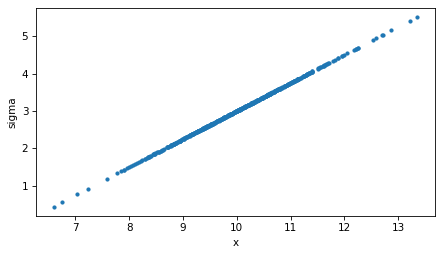

In [210]:
plt.plot(xs, sigmas, '.')

decorate(xlabel='x',
         ylabel='sigma')

Now we can generate `ys` with variable values of `sigma`.

In [211]:
ys = 0.5 * xs + np.random.normal(0, sigmas)

If we make a scatter plot of the data, we see the cone shape that is indicative of heteroskedasticity.

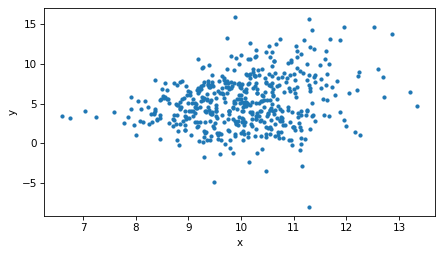

In [212]:
plt.plot(xs, ys, '.')

decorate(xlabel='x', ylabel='y')

The variability on the right is wider than on the left.
If we compute a linear regression, the estimated parameters are close to the true values, `slope = 0.5` and `intercept = 0`.
And the standard error seems plausible.

In [213]:
from scipy.stats import linregress

res = linregress(xs, ys)
res._asdict()

{'slope': 0.7635164953137031,
 'intercept': -2.445174431596821,
 'rvalue': 0.23424100257214234,
 'pvalue': 1.1671244052079876e-07,
 'stderr': 0.14199951914605377,
 'intercept_stderr': 1.4303879408696754}

Here's the data again with the fitted line.

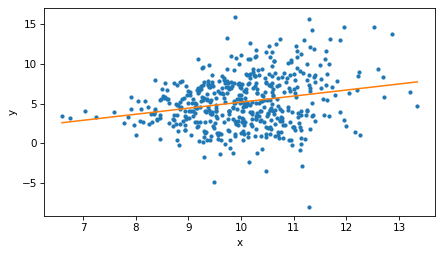

In [214]:
fys = res.intercept + res.slope * xs

plt.plot(xs, ys, '.')
plt.plot(xs, fys)

decorate(xlabel='x', ylabel='y')

If we plot the absolute values of the residuals, we can see the heteroskedasticity more clearly.

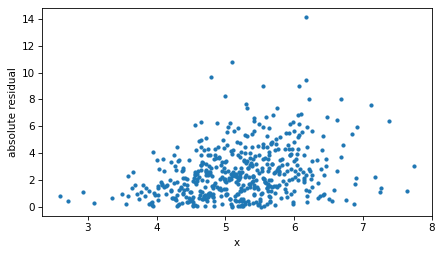

In [215]:
resid = ys - fys
plt.plot(fys, np.abs(resid), '.')

decorate(xlabel='x', ylabel='absolute residual')

Now, to see if the standard error we got from `linregress` is correct, we'll compute it again by bootstrapping.

In [216]:
heterosked = pd.DataFrame(dict(x=xs, y=ys))
heterosked.corr()

,x,y
x,1.000000,0.234241
y,0.234241,1.000000


The following function takes a `DataFrame` containing `x` and `y`, resamples the rows, and compute the slope of the regression line.

In [217]:
def resample_slope(df):
    resampled = df.sample(frac=1, replace=True)
    res = linregress(resampled['x'], resampled['y'])
    return res.slope

If we call this function many times, the result is a sample from the sampling distribution of the slopes.

In [218]:
sample = [resample_slope(heterosked) for i in range(1001)]

Here's what it looks like.

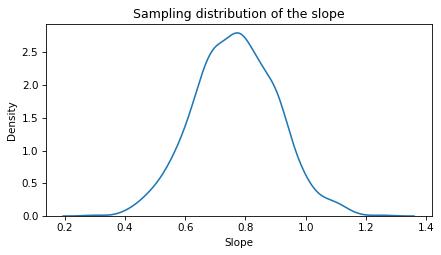

In [219]:
sns.kdeplot(sample)
decorate(xlabel='Slope',
         ylabel='Density',
         title='Sampling distribution of the slope')

The standard deviation of the sampling distribution is the standard error of the estimate.

In [220]:
stderr = np.std(sample)
stderr

0.1363140720080005

The result is only slightly bigger than what we got from `linregress`.

In [221]:
res.stderr

0.14199951914605377

In [226]:
import statsmodels.api as sm

# Fit a robust linear model
huber_model = sm.RLM(ys, sm.add_constant(xs), M=sm.robust.norms.HuberT())
huber_results = huber_model.fit()

# Print the summary of the model
print(huber_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  500
Model:                            RLM   Df Residuals:                      498
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 09 May 2024                                         
Time:                        15:43:47                                         
No. Iterations:                    16                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9266      1.421     -1.356      0.1

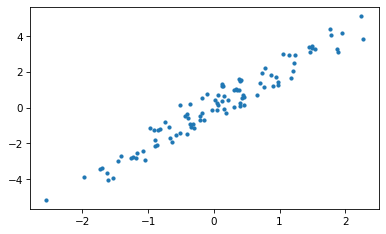

In [235]:
import numpy as np
import statsmodels.api as sm

# Generate some example data
np.random.seed(0)
X = np.random.randn(100)
y = 2 * X + np.random.normal(scale=0.5, size=100)

# Add heteroskedasticity to the residuals
heteroskedasticity = np.abs(X) * np.random.normal(scale=0.1, size=100)
y += heteroskedasticity

plt.plot(X, y, '.')

In [232]:
linregress(X, y)._asdict()

{'slope': 2.063616142893223,
 'intercept': 0.03530453795577457,
 'rvalue': 0.9702771706955395,
 'pvalue': 3.398675892587518e-62,
 'stderr': 0.051991075550735066,
 'intercept_stderr': 0.0524930596559468}

In [229]:
# Fit a robust linear model
huber_model = sm.RLM(y, sm.add_constant(X), M=sm.robust.norms.HuberT())
huber_results = huber_model.fit()

# Print the summary of the model
print(huber_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  100
Model:                            RLM   Df Residuals:                       98
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 09 May 2024                                         
Time:                        15:45:30                                         
No. Iterations:                    15                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0196      0.058      0.336      0.7

## Plotting

In [222]:
def resample_fit(df, xs):
    resampled = df.sample(frac=1, replace=True)
    res = linregress(resampled.x, resampled.y)
    fys = res.intercept + res.slope * xs
    return fys

In [223]:
def plot_percentile_fits(df, xs):
    fits = [resample_fit(heterosked, xs) for i in range(101)]
    low, high = np.percentile(np.array(fits), [5, 95], axis=0)
    plt.fill_between(xs, low, high, alpha=0.2)

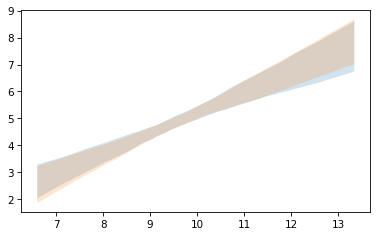

In [224]:
plot_percentile_fits(heterosked, xs)
plot_percentile_fits(homosked, xs)

[House Sales in King County, USA](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/data)

> This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

In [45]:
df = pd.read_csv('kc_house_data.csv')
df.shape

(21613, 21)

In [46]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [47]:
df['price'].describe()

count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [48]:
df['sqft_living'].describe()

count    21613.000000
mean      2079.899736
std        918.440897
min        290.000000
25%       1427.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

In [87]:
df['x'] = df['sqft_living']
df['y'] = df['price']

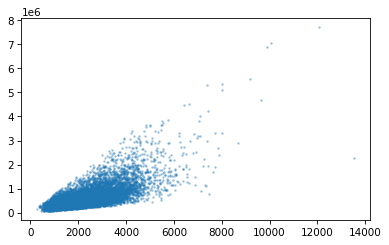

In [89]:
plt.plot(df['x'], df['y'], '.', ms=3, alpha=0.3)

In [90]:
linregress(xs, ys)._asdict()

{'slope': 280.6235678974483,
 'intercept': -43580.74309447408,
 'rvalue': 0.7020350546118003,
 'pvalue': 0.0,
 'stderr': 1.9363985519989133,
 'intercept_stderr': 4402.6896903039}

In [91]:
np.random.seed(17)
sample = [resample_slope(df) for i in range(1001)]

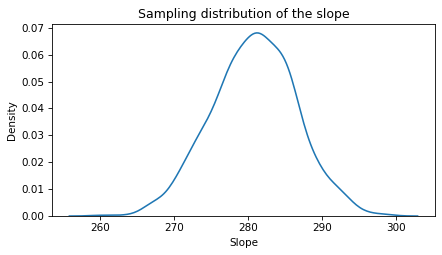

In [92]:
sns.kdeplot(sample)
decorate(xlabel='Slope',
         ylabel='Density',
         title='Sampling distribution of the slope')

In [93]:
stderr = np.std(sample)
stderr

5.6928606715328005

In [94]:
df['x'] = np.log10(df['sqft_living'])
df['y'] = np.log10(df['price'])

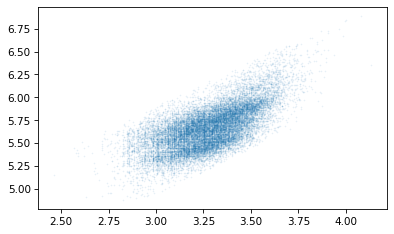

In [95]:
plt.plot(df['x'], df['y'], '.', ms=1, alpha=0.1)

In [96]:
linregress(df['x'], df['y'])._asdict()

{'slope': 0.8367709512512916,
 'intercept': 2.9227654505827516,
 'rvalue': 0.6749126345800395,
 'pvalue': 0.0,
 'stderr': 0.006223256908156434,
 'intercept_stderr': 0.020438758927378255}

In [97]:
np.random.seed(17)
sample = [resample_slope(df) for i in range(1001)]

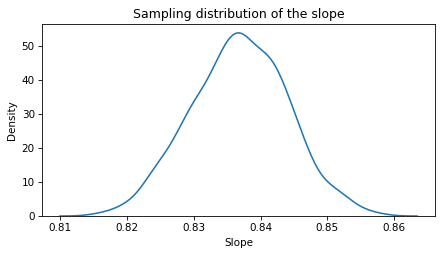

In [98]:
sns.kdeplot(sample)
decorate(xlabel='Slope',
         ylabel='Density',
         title='Sampling distribution of the slope')

In [99]:
stderr = np.std(sample)
stderr

0.007215926969243566

[*Data Q&A: Answering the real questions with Python*](https://allendowney.github.io/DataQnA/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)